In [2]:
import time
import functools
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler, swa_utils
import torchvision
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from diskcache import Cache

In [9]:

cache = Cache('.cache/diskcache')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = 'data/face_age'


@cache.memoize()
def imgpath_to_normalized_tensor(imgpath):
        # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
        return img


class Ageset(Dataset):
    def __init__(self, path, transforms = None, valid=False, split_pct = 0.3):
        self.image_paths = list(Path(path).rglob("*.png"))
        random.seed(42)
        random.shuffle(self.image_paths)
        split_point = int(len(self)*0.3)
        if valid:
            self.image_paths = self.image_paths[:split_point]
            print('len validation dataset', len(self.image_paths))
        else:
            self.image_paths = self.image_paths[split_point:]
            print('len train dataset', len(self.image_paths))
    def __len__(self):
        return len(self.image_paths)
    
    def show_image(self,i):
        return Image.open(self.image_paths[i])

    @classmethod # somehow this is needed for diskcache to work properly. Or define the function outside of the class
    @functools.lru_cache(maxsize=None)
    @cache.memoize()
    def imgpath_to_normalized_tensor(cls,imgpath):
            # makes a tensor, scales range to 0-1 and normalizes to same as imagenet
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
            img = normalize(transforms.PILToTensor()(Image.open(imgpath)).float()/255)
            return img
            
    def __getitem__(self,i):
        if isinstance(i, slice):
            # return [self[n] for n,_ in enumerate(self.image_paths[i])]
            # maybe better to return a new ageset to preserve the functions
            ret = copy.deepcopy(self)
            ret.image_paths = ret.image_paths[i]
            return ret

        return (self.imgpath_to_normalized_tensor(self.image_paths[i]),
                int(self.image_paths[i].parent.name))


In [10]:
def construct_tensor_dataset(path, max_len=None):
    # this took 20 GB RAM max
    image_paths = list(Path(path).rglob("*.png"))
    random.shuffle(image_paths)
    if max_len:
        image_paths = image_paths[:max_len]
    
    xs = torch.empty(len(image_paths), 3,200,200)
    print('empty created')
    for i, loc in enumerate(image_paths):
        if i%1000==0: print(i)
        xs[i] = imgpath_to_normalized_tensor(loc)
    torch.save(xs,'data/input/xs')

    print('done')

    ys = torch.stack([torch.Tensor([int(Path(loc).parent.name)]) for loc in image_paths])
    torch.save(ys,'data/input/ys')
    print('done')
    return None
# construct_tensor_dataset(PATH)

In [11]:
class AgeTensorDataset(TensorDataset):
    def __init__(self, xs, ys, valid=False, split_pct=0.3):
        length = len(xs)
        split = int(xs.shape[0]*split_pct)
        if valid:
            super().__init__(xs[:split],ys[:split])
        else:
            super().__init__(xs[split:],ys[split:])

    def __getitem__(self,x):
        return super().__getitem__(x)

In [12]:
class AgeResnet(nn.Module):
    def __init__(self, size='18', feat_extract=False):
        super().__init__()
        resnet = 'torchvision.models.resnet'+size+'(pretrained=True)'
        resnet = eval(resnet)
        modules=list(resnet.children())[:-1]
        self.resnet =nn.Sequential(*modules)

        if feat_extract:
            # with feature extraction we only train the linear layer and keep the resnet parameters fixed 
            for m in self.modules():
                m.requires_grad_(False)

        self.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self,x):
        out = self.resnet(x)
        x = torch.flatten(out, 1)
        return self.fc(x)

In [13]:
def determine_size(dataset):
    num_items = len(dataset)
    img_dimensions = list(dataset[0][0].shape)
    bytes_per_fp32 = 4
    bytes_per_gb = 1024**3
    size_in_gb = num_items * int(np.product(img_dimensions)) * bytes_per_fp32 / bytes_per_gb
    print('items in dataset', num_items, 'img_dimensions', img_dimensions, 'size of ds in memory in gb:', size_in_gb)

In [14]:
def train():
    best_loss = 1000000000
    best_model = None
    not_improve_count = 0
    loss = {'train':[], 'val':[]}

    for epoch in range(NUM_EPOCH):
        print(f'Starting epoch {epoch}')
        start_time = time.time()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0
            for data in dls[phase]:
                x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(x)
                    loss = loss_fn(y, pred)
                    total_loss += loss * len(y)
                    if phase == 'train':
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                        if SWA_ENABLED and epoch > SWA_START:
                            swa_model.update_parameters(model)
                            swa_sched.step()
                        elif SCHED_ENABLED:
                            sched.step(loss)
                            writer.add_scalar('lr/scheduler', sched.get_last_lr()[0], epoch)
                        writer.add_scalar('lr/optparamgroup0', opt.param_groups[0]['lr'], epoch)
                writer.add_scalar('batchloss/'+phase, loss, epoch)
            
            writer.add_scalar('loss/'+phase, total_loss/len(dls[phase].dataset), epoch)
    
        if total_loss < best_loss:
            best_loss = total_loss
            best_model = copy.deepcopy(model.state_dict())
            not_improve_count = 0
        else:
            not_improve_count += 1
            if not_improve_count > 300:
                print('early stopping!')
                break
           
        print(f"loss after epoch {epoch} : {total_loss / len(dls['val'].dataset)}")
        writer.add_scalar('time', (time.time()-start_time)/60, epoch)


    if SWA_ENABLED:
        swa_model.to('cpu')
        swa_utils.update_bn(train_dl, swa_model)
        swa_model.to(DEVICE)
        total_loss_train = 0
        total_loss_val = 0

        with torch.no_grad():
            for data in train_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_train += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/train', total_loss_train/len(train_set), epoch+1)
            swa_model.eval()

            for data in val_dl:
                    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
                    total_loss_val += loss_fn(y, model(x)) * len(y)
            writer.add_scalar('loss/val', total_loss_train/len(val_set), epoch+1)
        swa_model.avg_fn=None
        torch.save(swa_model.state_dict() ,'data/models/'+'swa_model'+str((total_loss_val/len(val_set)).item()))
    torch.save(best_model,'data/models/'+'model'+str((best_loss/len(val_set)).item()))
    writer.flush()
    writer.close()

In [15]:
# adam works best with lr of 0.001 (tested 0.1 and 0.01)
# adam without scheduler works best
# first it took 6 minutes to load all the datasets. With lru cache it was immediate (6GB memory use). With disk cache it took about 1-2 minutes. Great result. Finally what worked even better is not do any preloading, but just lru_cache getitem. This shaved off the initial preloading 
# feature extraction led to MSE of 12 after 40 epochs. Didnt really work. Maybe unfreeze more
# adam was outperformed in feature extraction, but for finetuning it worked better
# larger bs converges better and runs sligthly faster (about 10%) [512, 256,64,8]
# SWA gives an extreme improvement, from loss 3.7 to 2.7!!, ran 40 epochs, then 15 SWA epochs

# import adabound

def mae_loss(y, pred):
    return (torch.abs(y-pred.T)).mean()
loss_fn = mae_loss

NUM_EPOCH = 40
SWA_START = 25
LR = 0.001
BATCH_SIZE = 512
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SWA_ENABLED = True
SCHED_ENABLED = False

torch.cuda.empty_cache()
# xs = torch.load('data/input/xs').to(DEVICE)
# ys = torch.load('data/input/ys').to(DEVICE)

# train_set = AgeTensorDataset(xs,ys, valid=False)
train_set = Ageset("data/face_age")
determine_size(train_set)
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# val_set = AgeTensorDataset(xs,ys, valid=True)
val_set = Ageset("data/face_age", valid=True)[:1000]
determine_size(val_set) 
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
dls = {'train': train_dl, 'val': val_dl}

feat={True:'feat_ext', False:'finetune'}
opts = {0:'adam',1:'adabound'}

for i in [False]:
    for j in range(1):
        for BATCH_SIZE in [256]:
            for res in [18]:

                torch.cuda.empty_cache()



                writer = SummaryWriter(comment=f'{feat[i]} opt {opts[j]} epoch {NUM_EPOCH} SWA_START {SWA_START} LR BATCH_SIZE {LR}')
                model = AgeResnet(size=str(res), feat_extract=i)
                model = model.to(DEVICE)

                if j ==0:
                    opt = torch.optim.Adam(model.parameters(), LR)
                if j ==1:
                    opt = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)


                if SCHED_ENABLED:
                    # if i ==0:
                    #     sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
                    #     sched.get_last_lr = lambda: [1]
                    # if i == 1:
                    #     sched = torch.optim.lr_scheduler.OneCycleLR(opt, LR, steps_per_epoch=len(train_dl), epochs=NUM_EPOCH)
                    # if i == 2:
                    sched = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda=lambda x: 1)
                if SWA_ENABLED:
                    swa_model = swa_utils.AveragedModel(model)
                    swa_sched = swa_utils.SWALR(opt, swa_lr = 0.0005)
                train()

len train dataset 6845
items in dataset 6845 img_dimensions [3, 200, 200] size of ds in memory in gb: 3.059953451156616
len validation dataset 2933
items in dataset 1000 img_dimensions [3, 200, 200] size of ds in memory in gb: 0.4470348358154297
Starting epoch 0
loss after epoch 0 : 13.326348304748535
Starting epoch 1
loss after epoch 1 : 11.836812973022461
Starting epoch 2
loss after epoch 2 : 8.38664722442627
Starting epoch 3
loss after epoch 3 : 6.598114013671875
Starting epoch 4
loss after epoch 4 : 7.213953495025635
Starting epoch 5
loss after epoch 5 : 5.691191673278809
Starting epoch 6
loss after epoch 6 : 5.945230007171631
Starting epoch 7
loss after epoch 7 : 4.857588768005371
Starting epoch 8
loss after epoch 8 : 5.171734809875488
Starting epoch 9
loss after epoch 9 : 4.831895351409912
Starting epoch 10
loss after epoch 10 : 5.157435894012451
Starting epoch 11
loss after epoch 11 : 5.084877014160156
Starting epoch 12
loss after epoch 12 : 5.684683322906494
Starting epoch 13
l

In [16]:
model=swa_model

In [17]:
def gen_pred_df(model, val_items=None):
    model.eval()
    model.to(DEVICE)
    
    val_set = Ageset("data/face_age", valid=True)[:val_items] if val_items else Ageset("data/face_age", valid=True)
    data =[(model(x[None].to(DEVICE)).item(),y) for x,y in val_set]
    df = pd.DataFrame(data, columns=['pred', 'actual'])
    df['loss'] = abs(df['pred']-df['actual'])
    df['path'] = val_set.image_paths
    print(f"MAE, {df['loss'].mean()}, median {df['loss'].median()}")
    return df

In [22]:
def plot_top_losses(df):
    #plots top 9 of the dataframe
    df = df.sort_values('loss', ascending=False)

    fig,ax = plt.subplots(3,3,figsize=(10,10))
    val_set = Ageset('data/face_age', valid=True)
    for i, a in enumerate(ax.flat):
        # x,y = Ageset('data/face_age')[i]
        pred = int(df.iloc[i]['pred']) #model(x)
        actual  = df.iloc[i]['actual']
        human = '?'
        a.set_ylabel('44')
        a.imshow(val_set.show_image(df.iloc[i].name))
        a.set_title('#'+ str(df.iloc[i].name) + ' Actual: ' + str(actual), size=14)
        a.text(0,0, str(human), ha='right', size=14)
        a.text(200,0, str(pred), size=14)
        a.axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.1)
model = AgeResnet()
model.load_state_dict(torch.load('app/models/model4.3',map_location=torch.device('cpu')))
start = time.time()
df = gen_pred_df(model)
print(time.time()-start)
# plot_top_losses(df)

len validation dataset 2933
MAE, 4.263866104401504, median 2.5037240982055664
43.92166304588318


In [24]:
model = AgeResnet()
model = swa_utils.AveragedModel(model)
model.load_state_dict(torch.load('app/models/swa_model4.52',map_location=torch.device('cpu')))
start = time.time()
df = gen_pred_df(model)
print(time.time()-start)

len validation dataset 2933
MAE, 4.219434070548546, median 2.5105857849121094
43.98286819458008


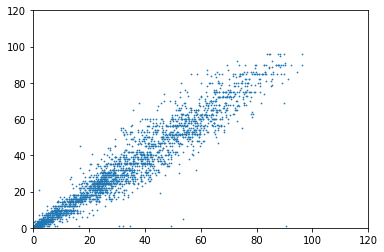

In [19]:
plt.figsize=(15,10)
plt.axis([0,120, 0, 120])
plt.scatter(df['pred'],df['actual'], s=0.5)

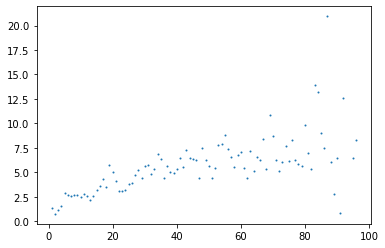

In [20]:
group = df.groupby(['actual']).agg(['count','mean'])
plt.scatter(group.index, group['loss']['mean'], s=1)

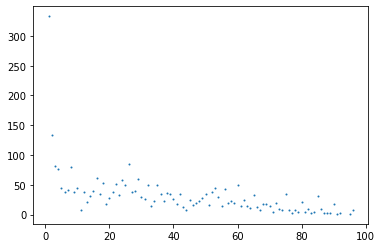

In [21]:
plt.scatter(group.index, group['loss']['count'], s=1)

<All keys matched successfully>

In [ ]:
#launch tensorboard
python -m tensorboard.main --logdir=runs --host=0.0.0.0 --port=6006

In [ ]:
tensorboard dev upload --logdir runs \
--name "My latest experiment" \ # optional
--description "Simple comparison of several hyperparameters" # optional

In [32]:
from IPython.display import display, HTML
display(HTML(df.to_html()))

,x,img
0,21.831789,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006280>
1,1.174410,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006F10>
2,58.658821,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE73006D60>
3,80.394730,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730062E0>
4,51.555397,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFAC0>
5,17.916960,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFB20>
6,1.145433,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFF10>
7,1.706568,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FFC70>
8,4.145883,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FF370>
9,12.813898,<PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x200 at 0x7FEE730FF640>


In [16]:
total_loss_val = 0
for data in val_dl:
    x, y = data[0].to(DEVICE), data[1].to(DEVICE)
    total_loss_val += loss_fn(y, model(x)) * len(y)

RuntimeError: CUDA out of memory. Tried to allocate 1.22 GiB (GPU 0; 11.17 GiB total capacity; 10.40 GiB already allocated; 29.44 MiB free; 10.80 GiB reserved in total by PyTorch)

In [27]:
torch.cuda.empty_cache()

In [25]:
def save_preds_for_app(df):
    df['pred']= df['pred'].astype(int)
    df['path']= df['path'].astype(str)
    # saving something as pickle file
    import pickle
    with open('app/models/predictions.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
save_preds_for_app(df)     